# Surrogate data generation

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from os.path import join
from data_functions import get_ant_datafiles_info, preprocess_antcolony_data
import multiSyncPy
from scipy.stats import rankdata
from numpy.fft import fft, ifft

In [2]:
def get_nth_colony(n):
    ant_data = get_ant_datafiles_info()
    df = preprocess_antcolony_data(ant_data['file'][n])
    return df

In [12]:
def get_data():
    # set colonies to be a global variable
    global colonies
    colonies = []
    for i in range (10):
        colonies.append(f'df{i}')
        exec(f'df{i} = get_nth_colony({i})')

In [5]:
colonies

['df0', 'df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9']

## AAFT

In [146]:
def aaft(data):
    # Transform the data into ranks and create sorted Gaussian noise
    ranks = rankdata(data, method='ordinal')
    random_data = np.random.normal(size=len(data))
    random_sorted = np.sort(random_data)

    # Initialize the surrogate with Gaussian data according to original data ranks
    surrogate = random_sorted[np.argsort(np.argsort(ranks))]

    # Apply Fourier transform
    fourier_transform = fft(surrogate)
    random_phases = np.exp(2j * np.pi * np.random.random(size=len(data)))

    # Adjust Fourier components by random phases and inverse Fourier transform
    adjusted_fourier = fourier_transform * random_phases
    new_surrogate = ifft(adjusted_fourier).real

    # Match the sorted surrogate to the original data's sorting
    final_surrogate = np.empty_like(data)
    final_surrogate[np.argsort(data)] = np.sort(new_surrogate)

    return final_surrogate

'''
# Create a DataFrame to store surrogate data
surrogate_data = pd.DataFrame(columns=['ant_id', 'surrogate_x', 'surrogate_y'])

# Apply AAFT for each ant's 'x' and 'y' data
for ant_id in df['ant_id'].unique():
    ant_data = df[df['ant_id'] == ant_id]
    surrogate_x = aaft(ant_data['x'].values)
    surrogate_y = aaft(ant_data['y'].values)
    surrogate_data.loc[len(surrogate_data)] = {'ant_id': ant_id, 'surrogate_x': surrogate_x, 'surrogate_y': surrogate_y}

# Optionally, save or display the surrogate data
print(surrogate_data.head())
# surrogate_data.to_csv('surrogate_ant_data.csv', index=False)
'''


"\n# Create a DataFrame to store surrogate data\nsurrogate_data = pd.DataFrame(columns=['ant_id', 'surrogate_x', 'surrogate_y'])\n\n# Apply AAFT for each ant's 'x' and 'y' data\nfor ant_id in df['ant_id'].unique():\n    ant_data = df[df['ant_id'] == ant_id]\n    surrogate_x = aaft(ant_data['x'].values)\n    surrogate_y = aaft(ant_data['y'].values)\n    surrogate_data.loc[len(surrogate_data)] = {'ant_id': ant_id, 'surrogate_x': surrogate_x, 'surrogate_y': surrogate_y}\n\n# Optionally, save or display the surrogate data\nprint(surrogate_data.head())\n# surrogate_data.to_csv('surrogate_ant_data.csv', index=False)\n"

In [19]:
# plot the trajectory of ants in a colony
def trajectory_plot(df):
    ant_id = df['ant_id'].unique()[0]
    # convert array to pandas series
    for i in df['ant_id'].unique():
        ant_surrogate_x = pd.Series(df.loc[df['ant_id'] == i, 'x'])
        ant_surrogate_y = pd.Series(df.loc[df['ant_id'] == i, 'y'])
        # plot the trajectory
        plt.plot(ant_surrogate_x, ant_surrogate_y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Trajectory of ants')
    plt.show()

In [148]:
# read in surr1_ants_seq0.csv to a pandas dataframe
for i in [0, 7, 8]:
    filepath = join('dataset', 'ants', 'csvs', f'surr1_ants_seq{i}.csv')
    exec(f'sdf{i} = pd.read_csv(filepath)')


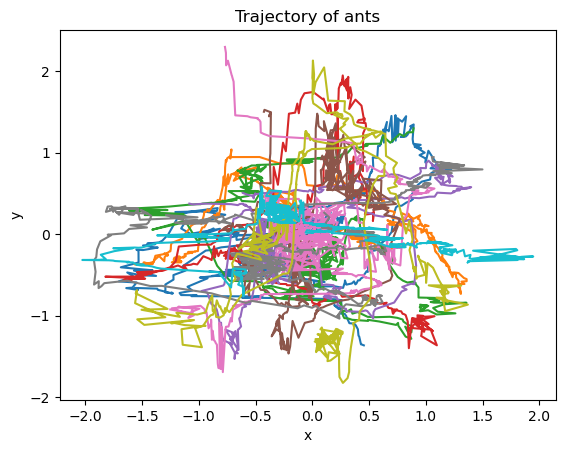

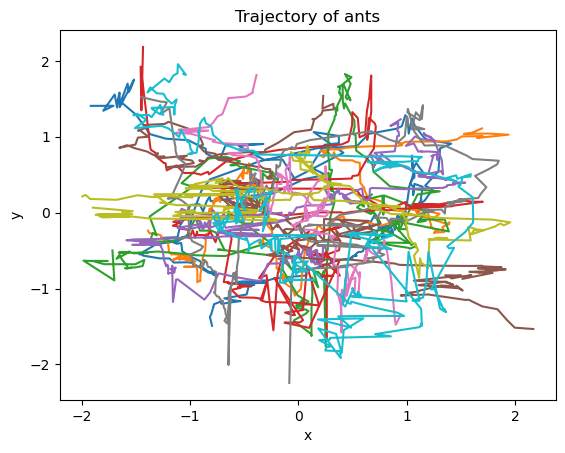

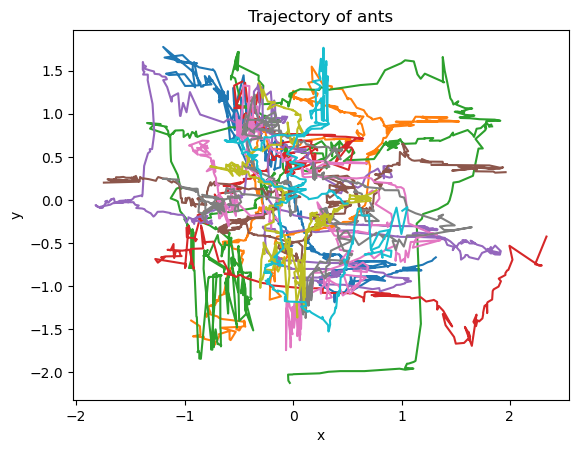

In [149]:
trajectory_plot(sdf0)
trajectory_plot(sdf7)
trajectory_plot(sdf8)

## Data shuffling

#### Setup 

In [150]:
colonies = [ ]
for i in range (10):
    colonies.append(f'df{i}')
    exec(f'df{i} = get_nth_colony({i})')

- extract change in x and y coordinates
- shuffle change
- calculate new x and y coordinates
- plug into dataframe

In [5]:
def get_change(df):
    # for each ant_id subtract the previous value (row above) from the current value (current row)
    df['dx'] = df.groupby('ant_id')['x'].diff()
    df['dy'] = df.groupby('ant_id')['y'].diff()
    # fill the NaN values with 0 at 'dx' and 'dy' columns
    df['dx'].fillna(0, inplace=True)
    df['dy'].fillna(0, inplace=True)
    
#get_change(df0)

In [6]:
def shuffle_change(df):
    # for each ant_id shuffle the x_change and y_change values
    for ant_id in df['ant_id'].unique():
        ant_data = df[df['ant_id'] == ant_id]
        ant_data['dx'] = np.random.permutation(ant_data['dx'])
        ant_data['dy'] = np.random.permutation(ant_data['dy'])
        df[df['ant_id'] == ant_id] = ant_data
        print(ant_data['dx'].sum(), ant_data['dy'].sum())

# shuffle_change(df0)

In [7]:
def calculate_new_xy(df: pd.DataFrame):
    # for each ant_id calculate the new x and y values
    for ant_id in df['ant_id'].unique():
        ant_data = df[df['ant_id'] == ant_id]
        # iterate over ant_data and calculate the new x and y values, each new value is the sum of the previous value and the change
        for i in range(1, len(ant_data)):
            ant_data.iloc[i, ant_data.columns.get_loc('x')] = ant_data.iloc[i-1]['x'] + ant_data.iloc[i]['dx']
            ant_data.iloc[i, ant_data.columns.get_loc('y')] = ant_data.iloc[i-1]['y'] + ant_data.iloc[i]['dy']
        df[df['ant_id'] == ant_id] = ant_data


#calculate_new_xy(df0)

In [159]:
df0[df0['ant_id'] == 11 ]['dx'].sum()

-120.90699999999993

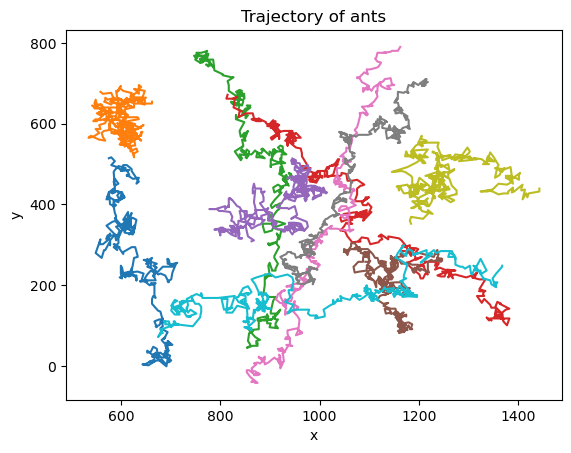

In [168]:
# plot the trajectory of ants in a colony
def trajectory_plot(df):
    ant_id = df['ant_id'].unique()[0]
    # convert array to pandas series
    for i in df['ant_id'].unique():
        ant_surrogate_x = pd.Series(df.loc[df['ant_id'] == i, 'x'])
        ant_surrogate_y = pd.Series(df.loc[df['ant_id'] == i, 'y'])
        # plot the trajectory
        plt.plot(ant_surrogate_x, ant_surrogate_y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Trajectory of ants')
    plt.show()

trajectory_plot(df0)

In [133]:
# save the data

## segment shuffling

In [169]:
colonies = [ ]
for i in range (10):
    colonies.append(f'df{i}')
    exec(f'df{i} = get_nth_colony({i})') 

get_change(df0)

/tmp/ipykernel_1244109/136273588.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dx'].fillna(0, inplace=True)
/tmp/ipykernel_1244109/136273588.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [8]:
def shuffle_change_segments(df, segm_length):
    # Create a new DataFrame to store shuffled data
    shuffled_df = pd.DataFrame()
    
    # Iterate over each unique ant_id
    for ant_id in df['ant_id'].unique():
        ant_data = df[df['ant_id'] == ant_id].copy()  # Make a copy of the ant data
        
        # Calculate the number of full segments
        full_segments_count = len(ant_data) // segm_length
        
        # Extract full segments
        segments = []
        for i in range(full_segments_count):
            start_index = i * segm_length
            end_index = start_index + segm_length
            segments.append(ant_data.iloc[start_index:end_index])
        
        # Handle any remaining data that didn't fit into a full segment
        if len(ant_data) % segm_length != 0:
            segments.append(ant_data.iloc[full_segments_count * segm_length:])
        
        # Shuffle the segments
        np.random.shuffle(segments)
        
        # Concatenate shuffled segments back together
        shuffled_segments = pd.concat(segments, ignore_index=True)
        
        # Assign the shuffled data back to the appropriate rows in the main DataFrame
        df.loc[df['ant_id'] == ant_id, ['dx', 'dy']] = shuffled_segments[['dx', 'dy']].values
    
    return df

#shuffle_change_segments(df0, 10)


In [171]:
calculate_new_xy(df0)

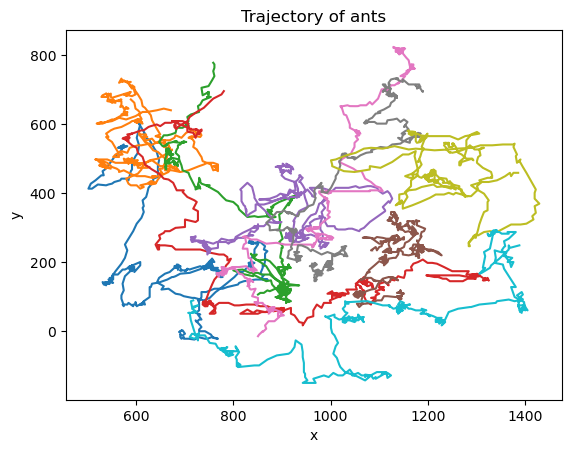

In [172]:
trajectory_plot(df0)

In [179]:
def segm_shuffle(df, segsize):
    get_change(df)
    shuffle_change_segments(df, segsize)
    calculate_new_xy(df)
    trajectory_plot(df)

In [182]:
df2

,frameno,ant_id,x,y,next_x,next_y,speed,angle,cos(angle),dx,dy
0,1,41,514.661,712.495,509.825,702.822,10.814519,1.107190,4.471766e-01,2.419,-4.836
1,1,42,618.641,579.497,596.878,594.006,26.156056,-0.588013,8.320444e-01,4.840,29.018
2,1,43,807.256,156.324,804.838,165.996,9.969669,-1.325818,2.425356e-01,19.345,0.000
3,1,44,920.908,187.759,920.908,185.341,2.418000,-1.570796,6.123234e-17,2.418,2.419
4,1,45,896.727,502.117,899.145,502.117,2.418000,0.000000,1.000000e+00,-2.418,0.000
...,...,...,...,...,...,...,...,...,...,...,...
3505,351,46,734.721,180.506,NaN,NaN,NaN,NaN,NaN,7.260,4.837
3506,351,47,830.701,157.701,NaN,NaN,NaN,NaN,NaN,0.000,-19.346
3507,351,48,555.776,480.355,NaN,NaN,NaN,NaN,NaN,-4.840,-2.418
3508,351,49,1143.379,185.342,NaN,NaN,NaN,NaN,NaN,-16.927,0.000


/tmp/ipykernel_1244109/136273588.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dx'].fillna(0, inplace=True)
/tmp/ipykernel_1244109/136273588.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

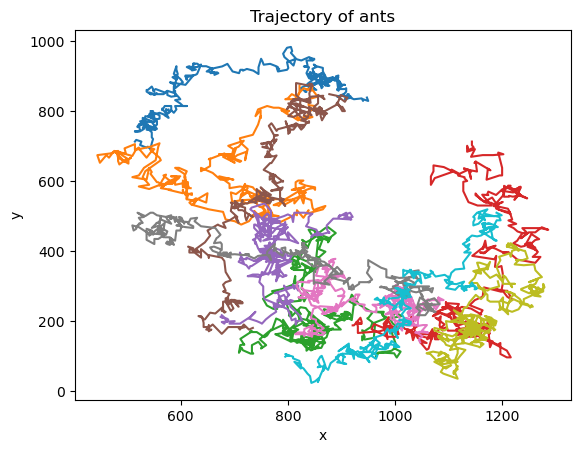

In [181]:
segm_shuffle(df2, 1)

In [21]:
from SurrogateGenerator import segm_shuffle

/tmp/ipykernel_1299228/4032697634.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dx'].fillna(0, inplace=True)
/tmp/ipykernel_1299228/4032697634.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

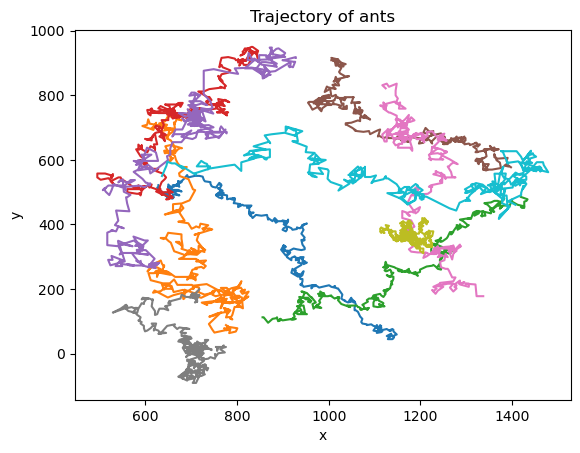

In [20]:


t = segm_shuffle(1, 1)
trajectory_plot(t)

## Plug into dataset (ignore column other than 'x' and 'y')

### AAFT

In [138]:

def get_nth_colony(n):
    ant_data = get_ant_datafiles_info()
    df = preprocess_antcolony_data(ant_data['file'][n])

    exec(f'df = df{i}')
    surrogate_data = pd.DataFrame(columns=['ant_id', 'surrogate_x', 'surrogate_y'])

    # Apply AAFT for each ant's 'x' and 'y' data
    for ant_id in df['ant_id'].unique():
        ant_data = df[df['ant_id'] == ant_id]
        surrogate_x = aaft(ant_data['x'].values)
        surrogate_y = aaft(ant_data['y'].values)
        
        # Use .loc to ensure changes are done on the original DataFrame
        df.loc[df['ant_id'] == ant_id, 'x'] = surrogate_x
        df.loc[df['ant_id'] == ant_id, 'y'] = surrogate_y
    filepath = join('dataset', 'ants', 'csvs', f'surr1_ants_seq{i}.csv')
    df.to_csv(filepath, index=False)
    print(f'Saved surrogate data for colony {i} to {filepath}')
    
    '''
    for ant_id in df['ant_id'].unique():
        ant_data = df[df['ant_id'] == ant_id]
        surrogate_x = aaft(ant_data['x'].values)
        surrogate_y = aaft(ant_data['y'].values)
        # convert surrogate_x to pandas series
        surrogate_x = pd.Series(surrogate_x)
        surrogate_y = pd.Series(surrogate_y)
        df[df['ant_id'] == ant_id]['x'] = surrogate_x
        df[df['ant_id'] == ant_id]['y'] = surrogate_y
        #df.loc[len(surrogate_data)] = {'ant_id': ant_id, 'surrogate_x': surrogate_x, 'surrogate_y': surrogate_y}

        #df['x'] = surrogate_x
        #df['y'] = surrogate_y
    '''

for i in [0, 7, 8]:
    get_nth_colony(i)

Saved surrogate data for colony 0 to dataset/ants/csvs/surr1_ants_seq0.csv
Saved surrogate data for colony 7 to dataset/ants/csvs/surr1_ants_seq7.csv
Saved surrogate data for colony 8 to dataset/ants/csvs/surr1_ants_seq8.csv


In [139]:
print(len(df0))
print(len(df7))
print(len(df8))

3510
2313
4529


In [140]:
# read csvs
df0 = pd.read_csv(join('dataset', 'ants', 'csvs', 'surr1_ants_seq0.csv'))
df7 = pd.read_csv(join('dataset', 'ants', 'csvs', 'surr1_ants_seq7.csv'))
df8 = pd.read_csv(join('dataset', 'ants', 'csvs', 'surr1_ants_seq8.csv'))
print(len(df0), len(df7), len(df8))
print(df0['x'].isna().sum(), df0['y'].isna().sum(), df7['x'].isna().sum(), df7['y'].isna().sum(), df8['x'].isna().sum(), df8['y'].isna().sum())

3510 2313 4529
0 0 0 0 0 0


In [141]:
print(df0[['x', 'y']])
print(df7[['x', 'y']])
print(df8[['x', 'y']])

             x         y
0     0.453898 -1.363879
1    -1.218673 -0.342053
2     0.891992  1.299430
3    -0.261754 -0.031701
4    -1.082935  0.375739
...        ...       ...
3505 -0.426394  1.502938
3506 -1.251270 -0.923721
3507  0.105631  0.264028
3508  0.074103 -1.427040
3509 -0.683238 -0.466699

[3510 rows x 2 columns]
             x         y
0    -0.797996 -1.491300
1     1.693258  1.110189
2     0.676580  0.239603
3    -0.817756 -1.372458
4     1.601343  1.051575
...        ...       ...
2308 -1.154156  1.806908
2309 -1.117005  1.837493
2310 -1.113390  1.956350
2311 -1.039388  1.815966
2312 -1.062915  1.826774

[2313 rows x 2 columns]
             x         y
0    -0.008822 -0.529902
1    -0.211564 -0.993804
2     1.835722  0.853517
3     2.337042 -0.424462
4    -0.110894 -0.751229
...        ...       ...
4524  1.960022  0.322333
4525  0.703767  0.083987
4526  0.579342  0.114994
4527 -0.315726  1.353854
4528  0.502513 -0.040787

[4529 rows x 2 columns]


In [142]:
'''
def get_nth_colony(n):
    ant_data = get_ant_datafiles_info()
    df = preprocess_antcolony_data(ant_data['file'][n])

    surrogate_data = pd.DataFrame(columns=['ant_id', 'surrogate_x', 'surrogate_y'])

    # Apply AAFT for each ant's 'x' and 'y' data
    for ant_id in df['ant_id'].unique():
        ant_data = df[df['ant_id'] == ant_id]
        surrogate_x = aaft(ant_data['x'].values)
        surrogate_y = aaft(ant_data['y'].values)

        # Update original DataFrame
        df.loc[df['ant_id'] == ant_id, 'x'] = surrogate_x
        df.loc[df['ant_id'] == ant_id, 'y'] = surrogate_y

        # Create a temporary DataFrame for current ant's data with expanded values
        temp_df = pd.DataFrame({
            'ant_id': ant_id,
            'surrogate_x': surrogate_x,
            'surrogate_y': surrogate_y
        })

        # Append current ant's expanded data to the surrogate_data DataFrame
        surrogate_data = pd.concat([surrogate_data, temp_df], ignore_index=True)

    filepath = join('dataset', 'ants', 'csvs', f'surr1_ants_seq{n}.csv')
    surrogate_data.to_csv(filepath, index=False)
    print(f'Saved surrogate data for colony {n} to {filepath}')

for i in [0, 7, 8]:
    get_nth_colony(i)
'''

"\ndef get_nth_colony(n):\n    ant_data = get_ant_datafiles_info()\n    df = preprocess_antcolony_data(ant_data['file'][n])\n\n    surrogate_data = pd.DataFrame(columns=['ant_id', 'surrogate_x', 'surrogate_y'])\n\n    # Apply AAFT for each ant's 'x' and 'y' data\n    for ant_id in df['ant_id'].unique():\n        ant_data = df[df['ant_id'] == ant_id]\n        surrogate_x = aaft(ant_data['x'].values)\n        surrogate_y = aaft(ant_data['y'].values)\n\n        # Update original DataFrame\n        df.loc[df['ant_id'] == ant_id, 'x'] = surrogate_x\n        df.loc[df['ant_id'] == ant_id, 'y'] = surrogate_y\n\n        # Create a temporary DataFrame for current ant's data with expanded values\n        temp_df = pd.DataFrame({\n            'ant_id': ant_id,\n            'surrogate_x': surrogate_x,\n            'surrogate_y': surrogate_y\n        })\n\n        # Append current ant's expanded data to the surrogate_data DataFrame\n        surrogate_data = pd.concat([surrogate_data, temp_df], igno